In [2]:
# >> Imports y configuración <<
import os
import sys
# >> reproducibilidad <<
RANDOM_STATE = 42

# >> Librerías principales <<
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# >> Scikit / ML / utilitarios <<
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib


In [3]:

# >> Funciones desde el workspace <<
sys.path.append(os.path.abspath(".."))
from functions import func_util

In [4]:
# >> carga datos <<
data_path = os.path.join('..', 'data', 'Crop_recommendation.csv')
df = pd.read_csv(data_path)
# >> vista rápida <<
# >> mostrar shape, dtypes, head <<
print(df.shape)
display(df.head())
display(df.info())

(2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


None

In [5]:

# >> Celdas 2: Limpieza básica y chequeos <<
# >> chequear nulos y duplicados <<
print("Nulos por columna:\n", df.isna().sum())
print("Duplicados:", df.duplicated().sum())
display(df.describe())


Nulos por columna:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Duplicados: 0


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


Conteo por cultivo:


label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

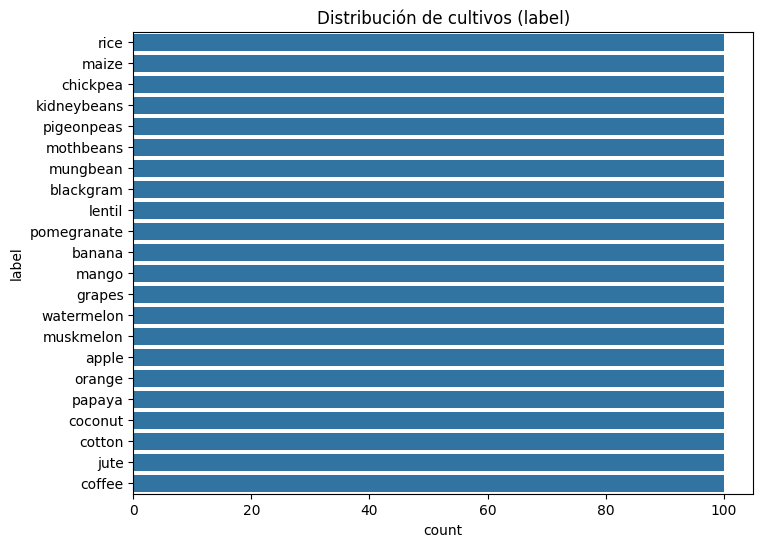

In [6]:

# >> Celdas 3: Target y balance de clases <<
print("Conteo por cultivo:")
display(df['label'].value_counts())
plt.figure(figsize=(8,6))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Distribución de cultivos (label)')
plt.show()


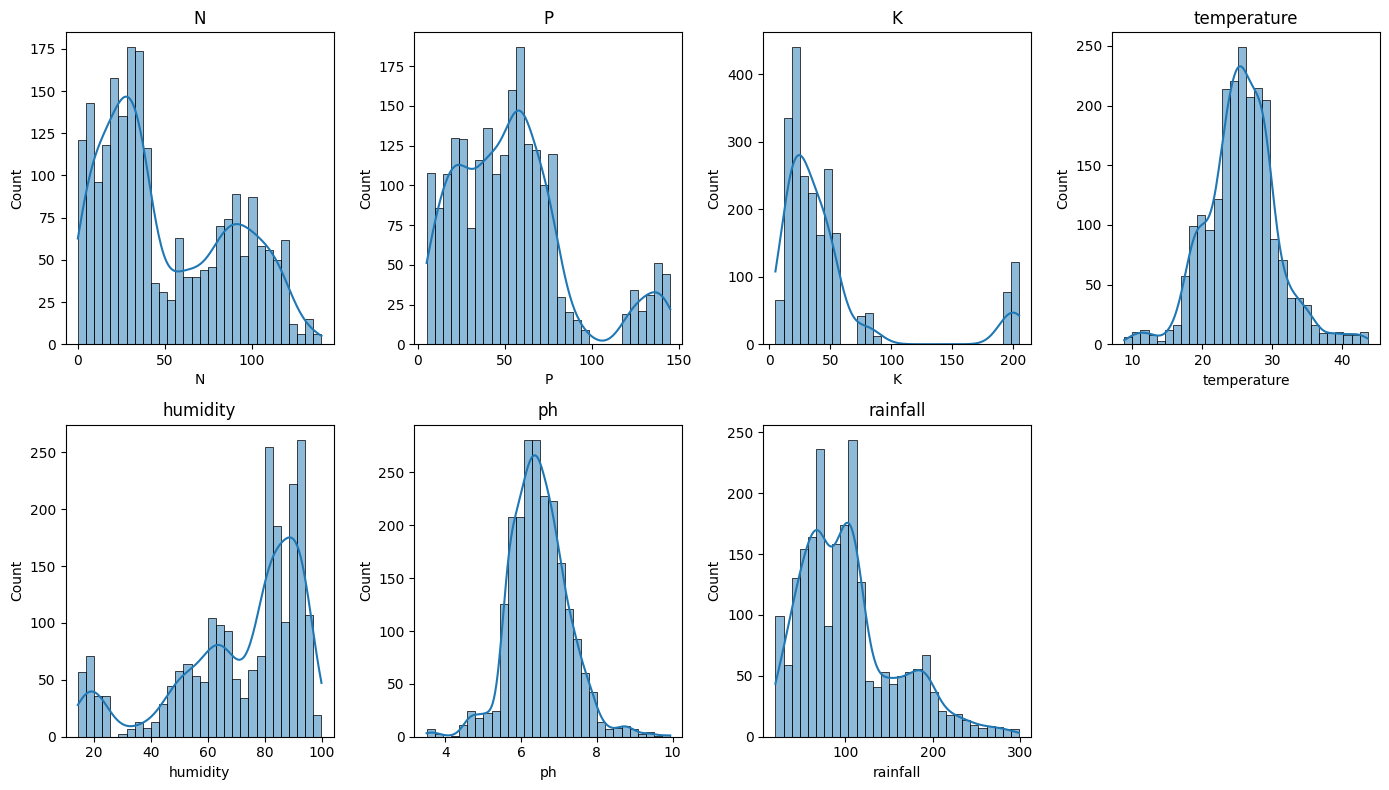

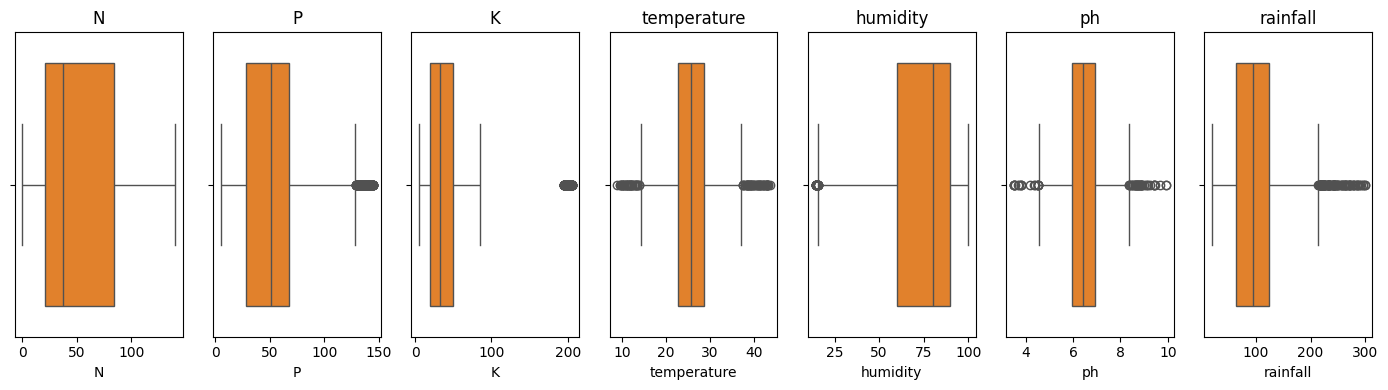

In [7]:

# >> Celdas 4: Univariado (hist + box) <<
num_cols = ['N','P','K','temperature','humidity','ph','rainfall']
plt.figure(figsize=(14,8))
for i, c in enumerate(num_cols, 1):
    plt.subplot(2,4,i)
    sns.histplot(df[c], bins=30, kde=True)
    plt.title(c)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
for i, c in enumerate(num_cols, 1):
    plt.subplot(1,7,i)
    sns.boxplot(x=df[c], color='C1')
    plt.title(c)
plt.tight_layout()
plt.show()


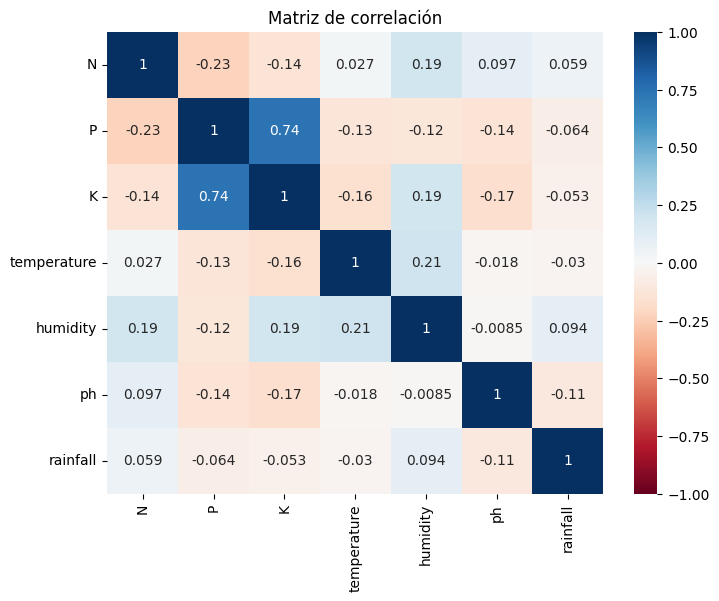

In [8]:

# >> Celdas 5: Correlación y multicolinealidad <<
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()


In [9]:

# >> Celdas 6: Detección de outliers (IQR) <<
def detect_iqr_outliers(series, k=1.5):
    """Detecta valores fuera de [Q1 - k*IQR, Q3 + k*IQR].
    Input: series (pd.Series), k (float)
    Output: mask boolean (True == outlier)
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)


In [10]:

# >> aplicar y mostrar resumen <<
outlier_summary = {c: detect_iqr_outliers(df[c]).sum() for c in num_cols}
print("Outliers por variable (IQR 1.5):", outlier_summary)


Outliers por variable (IQR 1.5): {'N': np.int64(0), 'P': np.int64(138), 'K': np.int64(200), 'temperature': np.int64(86), 'humidity': np.int64(30), 'ph': np.int64(57), 'rainfall': np.int64(100)}


,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
rice,80.0,47.0,40.0,23.734837,82.189357,6.363804,233.119859
jute,78.0,46.0,40.0,24.971106,79.469205,6.711500,175.590814
coconut,24.0,15.5,31.0,27.385317,94.960581,5.990709,171.999922
coffee,103.0,29.0,30.0,25.656643,57.648083,6.798626,157.770963
pigeonpeas,20.0,69.5,20.0,28.931707,47.195180,5.690466,154.310507
papaya,49.0,60.0,50.0,33.262870,92.681086,6.740830,139.000698
apple,24.0,136.5,200.0,22.628290,92.416541,5.885818,112.979230
orange,19.0,16.0,10.0,22.901055,91.963246,7.022614,110.684073
pomegranate,18.0,20.0,40.0,22.354425,89.911979,6.430715,107.588201


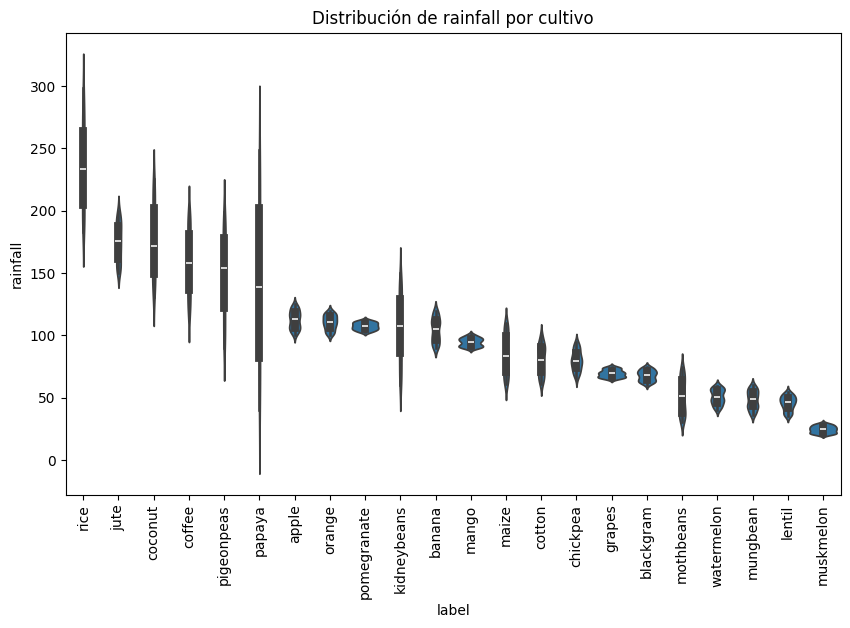

In [11]:

# >> Celdas 7: Perfil por cultivo (groupby + violin/box) <<
grp = df.groupby('label')[num_cols].median().sort_values('rainfall', ascending=False)
display(grp)
# >> violin para variables discriminantes <<
plt.figure(figsize=(10,6))
sns.violinplot(x='label', y='rainfall', data=df, order=grp.index)
plt.xticks(rotation=90)
plt.title('Distribución de rainfall por cultivo')
plt.show()


In [12]:
# >> Celdas 8: Feature engineering mínimos <<
# >> ejemplo: proporción de N sobre (P+K) <<
df['N_over_PK'] = df['N'] / (df['P'] + df['K'] + 1e-6)

# >> Celdas 9: Preparación para modelado <<
X = df.drop(columns=['label'])
y = df['label'].copy()
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE
)


Reporte clasificación (baseline):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00    

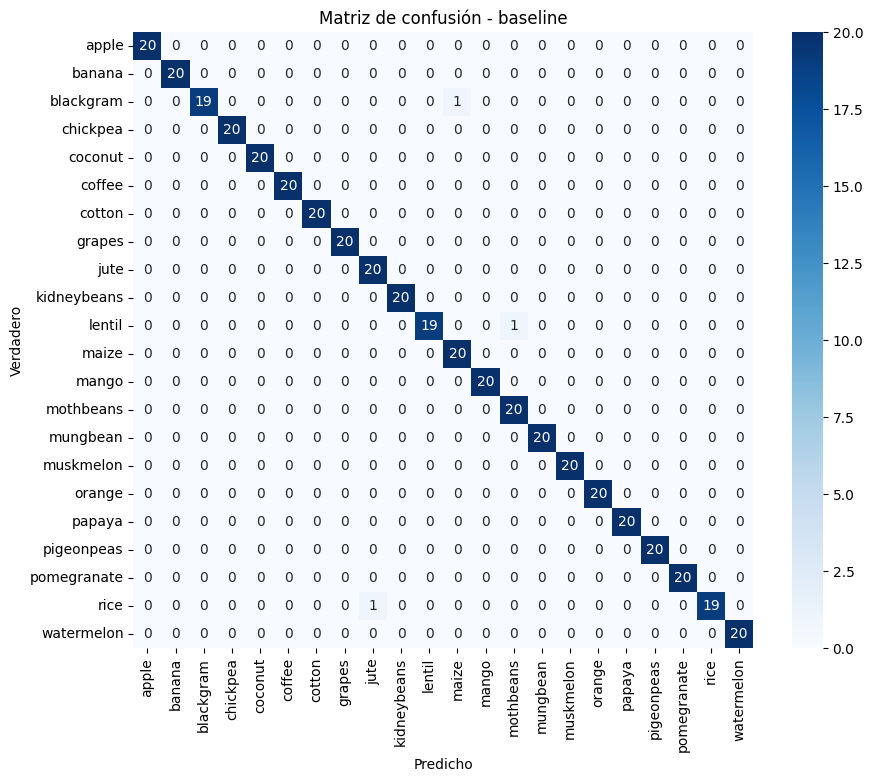

In [13]:

# >> Pipeline simple y baseline (RandomForest) <<
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Reporte clasificación (baseline):")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de confusión - baseline')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [14]:

# >> Celdas 10: Interpretabilidad (feature importances) <<
importances = pipeline.named_steps['clf'].feature_importances_
feat_names = X.columns.tolist()
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
display(imp_df.head(20))


,feature,importance
6,rainfall,0.206355
4,humidity,0.205244
2,K,0.167992
1,P,0.144263
0,N,0.081768
3,temperature,0.070695
7,N_over_PK,0.068202
5,ph,0.055480


In [15]:
# >> Celdas 11: Guardar artefactos para Streamlit <<
joblib.dump(pipeline, os.path.join('..','models','crop_recommender_rf.joblib'))
joblib.dump(le, os.path.join('..','models','label_encoder.joblib'))


['../models/label_encoder.joblib']

In [16]:
# >> comprobar directorio de trabajo y ruta absoluta <<
import os, joblib
print("cwd:", os.getcwd())

# >> ruta absoluta destino <<
target = os.path.abspath(os.path.join('..','models','crop_recommender_rf.joblib'))
print("target:", target)

# >> crear carpeta si no existe <<
os.makedirs(os.path.dirname(target), exist_ok=True)

# >> guardar y mostrar resultado <<
saved = joblib.dump(pipeline, target)
print("joblib.dump devolvió:", saved)  # lista con la ruta guardada

cwd: /home/christianr/Bootcamp_Data_e_IA/01_proyecto/notebooks
target: /home/christianr/Bootcamp_Data_e_IA/01_proyecto/models/crop_recommender_rf.joblib
joblib.dump devolvió: ['/home/christianr/Bootcamp_Data_e_IA/01_proyecto/models/crop_recommender_rf.joblib']


In [17]:
# >> Celdas 12: Exportar resumen automático a markdown <<
report_lines = []
report_lines.append("# Informe EDA - Recomendador de cultivos\n")
report_lines.append("## Resumen de datos\n")
report_lines.append(f"- Filas: {df.shape[0]}, Columnas: {df.shape[1]}\n")
report_lines.append("## Principales métricas baseline\n")
report_lines.append("```\n")
report_lines.append(classification_report(y_test, y_pred, target_names=le.classes_))
report_lines.append("```\n")

# >> crear directorio si no existe <<
reports_dir = os.path.join('..', 'reports')
os.makedirs(reports_dir, exist_ok=True)

# >> guardar reporte <<
report_path = os.path.join(reports_dir, 'eda_report.md')
with open(report_path, 'w', encoding='utf-8') as fh:
    fh.writelines("\n".join(report_lines))

print(f"Reporte guardado en: {os.path.abspath(report_path)}")

Reporte guardado en: /home/christianr/Bootcamp_Data_e_IA/01_proyecto/reports/eda_report.md
